## **Data**

* The primary data for the competition is, in each provided file, the comment_text column. This contains the text of a comment which has been classified as toxic or non-toxic (0...1 in the toxic column). The **train set’s comments are entirely in english** and come either from **Civil Comments** or **Wikipedia** talk page edits. The **test data**'s comment_text columns are **composed of multiple non-English languages.**

* The *-train.csv files and validation.csv file also contain a toxic column that is the target to be trained on.

* The **jigsaw-toxic-comment-train.csv** and **jigsaw-unintended-bias-train.csv** contain training data (comment_text and toxic) from the **two previous Jigsaw competitions**, as well as additional columns that you may find useful.

## Files
* jigsaw-toxic-comment-train.csv - data from our first competition. The dataset is made up of English comments from Wikipedia’s talk page edits.
* jigsaw-unintended-bias-train.csv - data from our second competition. This is an expanded version of the Civil Comments dataset with a range of additional labels.
* sample_submission.csv - a sample submission file in the correct format
* test.csv - comments from Wikipedia talk pages in different non-English languages.
* validation.csv - comments from Wikipedia talk pages in different non-English languages.
* jigsaw-toxic-comment-train-processed-seqlen128.csv - training data preprocessed for BERT
* jigsaw-unintended-bias-train-processed-seqlen128.csv - training data preprocessed for BERT
* validation-processed-seqlen128.csv - validation data preprocessed for BERT
* test-processed-seqlen128.csv - test data preprocessed for BERT

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

## Helper Functions

In [2]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## TPU Configs

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

## Create fast tokenizer

In [6]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Save the loaded tokenizer locally
save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, add_special_tokens=True, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

## Load text data into memory

In [7]:
!ls -al /kaggle/input/jigsaw-multilingual-toxic-comment-classification

total 4913512
drwxr-xr-x 2 nobody nogroup       4096 Mar 21 00:33 .
drwxr-xr-x 3 root   root          4096 Apr 17 15:36 ..
-rw-r--r-- 1 nobody nogroup  406706887 Mar 21 00:33 jigsaw-toxic-comment-train-processed-seqlen128.csv
-rw-r--r-- 1 nobody nogroup   95538001 Mar 21 00:33 jigsaw-toxic-comment-train.csv
-rw-r--r-- 1 nobody nogroup 3498299507 Mar 21 00:33 jigsaw-unintended-bias-train-processed-seqlen128.csv
-rw-r--r-- 1 nobody nogroup  860317123 Mar 21 00:33 jigsaw-unintended-bias-train.csv
-rw-r--r-- 1 nobody nogroup     627019 Mar 21 00:33 sample_submission.csv
-rw-r--r-- 1 nobody nogroup  122946125 Mar 21 00:33 test-processed-seqlen128.csv
-rw-r--r-- 1 nobody nogroup   28783206 Mar 21 00:33 test.csv
-rw-r--r-- 1 nobody nogroup   14997354 Mar 21 00:33 validation-processed-seqlen128.csv
-rw-r--r-- 1 nobody nogroup    3178555 Mar 21 00:33 validation.csv


In [8]:
# Engl comments from Wikipedia’s talk page
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
# Civil Comments dataset with a range of additionnal labels.
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
# comments from Wikipedia talk pages in different non-English languages.                     
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv') 
test_no_labels = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [9]:
train1.iloc[:4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


## Valid and test labeled data building

In [10]:
#test_no_labels : not used in this notebook because only used for Kaggle model evaluation only 
test_no_labels[0:4]

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr


In [11]:
valid.iloc[:4]
print ('valid shape:',valid.shape)

valid shape: (8000, 4)


In [12]:
# Evenly split valid data to build new valid ndtest labeled data
valid_with_labels = valid[0:3999]
test_with_labels = valid[4000:7999]

In [13]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_valid = fast_encode(valid_with_labels.comment_text.astype(str), fast_tokenizer, maxlen=512)
x_test = fast_encode(test_with_labels.comment_text.astype(str), fast_tokenizer, maxlen=512)

y_train = train1.toxic.values
y_valid = valid_with_labels.toxic.values
y_test = test_with_labels.toxic.values

## Build datasets objects

In [14]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)
   

## Load model into the TPU

In [15]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
    model = build_model(transformer_layer, max_len=512)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 512, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 31 s, sys: 11.3 s, total: 42.3 s
Wall time: 47.1 s


## Train Model

In [16]:
!ls /kaggle/working

__notebook_source__.ipynb  distilbert_base_uncased


In [17]:
import os
os.chdir(r'/kaggle/working')

In [27]:
Working_Out = '/kaggle/working'

#Save best weight model
ModelPath = Working_Out + '/weights_best_inception3_pool_over1.hdf5'
checkpointer = ModelCheckpoint(filepath = ModelPath, verbose=1, save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=100,
    validation_data=valid_dataset,
    epochs=5,
    #callbacks=[checkpointer]
)

Train for 100 steps, validate for 32 steps
Epoch 1/5
100/100 [==============================] - 38s 382ms/step - loss: 0.1514 - accuracy: 0.9439 - val_loss: 0.3678 - val_accuracy: 0.8500
Epoch 2/5
100/100 [==============================] - 24s 236ms/step - loss: 0.1333 - accuracy: 0.9493 - val_loss: 0.3622 - val_accuracy: 0.8522
Epoch 3/5
100/100 [==============================] - 24s 236ms/step - loss: 0.1207 - accuracy: 0.9551 - val_loss: 0.3635 - val_accuracy: 0.8527
Epoch 4/5
100/100 [==============================] - 24s 236ms/step - loss: 0.1137 - accuracy: 0.9580 - val_loss: 0.3726 - val_accuracy: 0.8550
Epoch 5/5
100/100 [==============================] - 24s 236ms/step - loss: 0.1061 - accuracy: 0.9605 - val_loss: 0.3936 - val_accuracy: 0.8500


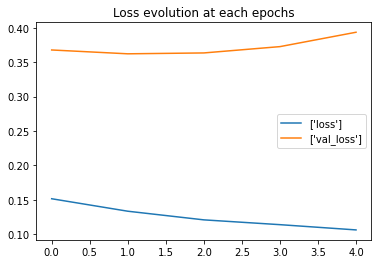

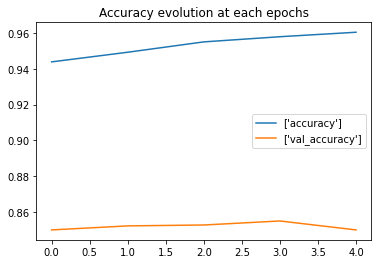

In [28]:
# Plot the training process 
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
 
plt.plot(train_loss, label=['loss'])
plt.plot(val_loss, label=['val_loss'])
plt.title('Loss evolution at each epochs')
plt.legend()
plt.show()

plt.plot(train_acc , label=['accuracy'])
plt.plot(val_acc , label=['val_accuracy'])
plt.title('Accuracy evolution at each epochs')
plt.legend()
plt.show()

## Test evaluation

In [29]:
print('\n# Evaluate')
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))


# Evaluate
32/32 [==============================] - 5s 151ms/step - loss: 0.3905 - accuracy: 0.8522


{'loss': 0.3905057134106755, 'accuracy': 0.8522131}

In [31]:

db = model.predict(test_dataset, verbose=1)

32/32 [==============================] - 5s 166ms/step
